In [101]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import geopandas as gpd
from __future__ import print_function, division
import matplotlib.pylab as plt
import pylab as pl
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import statsmodels.api as sm
import sys
import os
import urllib
import requests
import json
import zipfile
import shapely
import io
from io import StringIO

# Task 1

In [102]:
#Create the environmental variables for PUIDATA
os.environ["PUIDATA"] = "%s/PUIDATA"%os.getenv("HOME")
print("PUIDATA", os.getenv("PUIDATA"))

PUIDATA /nfshome/nbc270/PUIDATA


In [59]:
#Pull zip file as file.gz
urllib.request.urlretrieve('https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile', 'file.gz')

('file.gz', <http.client.HTTPMessage at 0x7ffb8e2d3a90>)

In [60]:
#Move file.gz to PUIDATA
!mv file.gz $PUIDATA

In [61]:
#Unzip file.gz
zip_ref = zipfile.ZipFile(os.getenv("PUIDATA") + '/file.gz', 'r')
zip_ref.extractall(os.getenv("PUIDATA"))
zip_ref.close()

In [62]:
#Create a geodataframe from the shapefile 
pumashp = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + '/geo_export_324fd851-649c-4ac7-812a-c6f6063aec80.shp')
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [63]:
pumashp.crs

{'init': 'epsg:4326'}

Text(0.5,1,'Figure 1: Outline of NYC PUMA Districts')

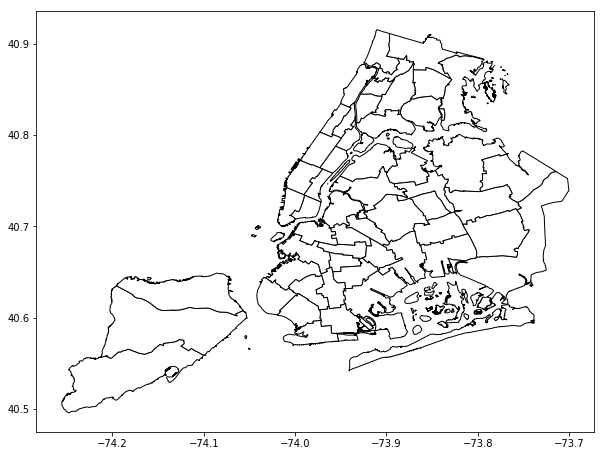

In [106]:
#Create black and white image
nyc = pumashp.to_crs(epsg='4326')
nyc.plot(color='white', edgecolor='black', figsize = (10,10))
ax.set_title("Figure 1: Outline of NYC PUMA Districts")

Figure 1 displays an outline of PUMA districs across NYC.

# Task 2

In [65]:
#Created an envrionmental variable 'KEY' for my API key
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)
myAPI = os.getenv('KEY')

In [66]:
#Read the JSON as an array
affkeys = np.array(list(aff1y['variables'].keys()))

In [67]:
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription')]

In [68]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [69]:
#Getting PUMA Household info
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [70]:
#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

In [71]:
#Getting PUMA Broadband Data
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [72]:
#Add the broadband data to the household dataframe. Calculate the percent housholds by dividing the number of broadband 
#using households by the number of households and mutiply by 100

pumaBB = pd.merge(pumaBB,pumaPP[['NAME','B28002_001E']],on='NAME', how='right')
pumaBB['pcBB'] = pumaBB['B28002_004E']/pumaPP['B28002_001E'] * 100
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,61146,78.150656


In [73]:
#Move the US Census FactFinding zip file (uploaded via SFTP from local machine to ADRF) to PUIDATA
!mv $HOME/ACS_16_1YR_GCT2801.ST50.zip $PUIDATA

mv: cannot stat '/nfshome/nbc270/ACS_16_1YR_GCT2801.ST50.zip': No such file or directory


In [74]:
#Unzip the file
zip_ref = zipfile.ZipFile(os.getenv("PUIDATA") + '/ACS_16_1YR_GCT2801.ST50.zip', 'r')
zip_ref.extractall(os.getenv("PUIDATA"))
zip_ref.close()

In [75]:
#Read in the file, remove the first row, and covert the first column into integers
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])
bbpc.drop(0, inplace=True)
bbpc['GCT_STUB.target-geo-id2'].astype(int)
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
1,36,81.7,0.2
2,3600100,80.6,2.6
3,3600200,75.7,2.2
4,3600300,79.8,2.6
5,3600401,81.4,2.4


In [76]:
#Convert first column name to gid
bbpc.columns = ['gid', 'HC01', 'HC02']
bbpc.head()

,gid,HC01,HC02
1,36,81.7,0.2
2,3600100,80.6,2.6
3,3600200,75.7,2.2
4,3600300,79.8,2.6
5,3600401,81.4,2.4


In [77]:
#Subtract 3600000 from gid
bbpc['gid'] = bbpc.gid.astype(int) - 3600000
bbpc.head()

,gid,HC01,HC02
1,-3599964,81.7,0.2
2,100,80.6,2.6
3,200,75.7,2.2
4,300,79.8,2.6
5,401,81.4,2.4


In [78]:
#Determine if there is a small max regard to the different between the two data tables. If not, proceed to data analysis.
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()

,pcBB,diff
count,145.000000,145.000000
mean,81.845478,0.026217
std,7.063369,0.014480
min,54.932945,0.000178
25%,77.770257,0.012252
50%,82.826141,0.027230
75%,87.305077,0.039090
max,93.404143,0.049872


# Task 3

In [79]:
#Convert 'puma' and 'public use microdata area' columns to integers and then merge the dataframes based on these values
nyc['puma'] = nyc['puma'].astype(int)
pumaBB['public use microdata area'] = pumaBB['public use microdata area'].astype(int)
combined_data = pd.merge(pumaBB, nyc, left_on = 'public use microdata area', how = 'outer', right_on = 'puma')
combined_data.tail()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E,pcBB,puma,shape_area,shape_leng,geometry
140,50844,"NYC-Queens Community District 5--Ridgewood, Gl...",36,4110,NaN,61570,82.579178,4110.0,2.050472e+08,71251.084890,POLYGON ((-73.89783236941891 40.73516035418231...
141,37570,NYC-Queens Community District 9--Richmond Hill...,36,4111,NaN,44811,83.841021,4111.0,1.326029e+08,56323.365530,POLYGON ((-73.82167849048575 40.71116601167973...
142,54603,"NYC-Queens Community District 12--Jamaica, Hol...",36,4112,NaN,71109,76.787748,4112.0,2.600517e+08,72781.304161,POLYGON ((-73.75725671377032 40.71813860165978...
143,32506,NYC-Queens Community District 10--Howard Beach...,36,4113,NaN,37998,85.546608,4113.0,1.714665e+08,110717.942782,(POLYGON ((-73.85722330984366 40.6502786705413...
144,32172,NYC-Queens Community District 14--Far Rockaway...,36,4114,NaN,41368,77.770257,4114.0,3.156828e+08,412606.741739,(POLYGON ((-73.83668274106707 40.5949466970158...


In [80]:
#Convert the dataframe into a geodataframe with the reference frame 4326
broadbandnyc = GeoDataFrame(combined_data)
broadbandnyc.crs = from_epsg(4326)
broadbandnyc.shape

(145, 11)

Text(0.5,1,'Figure 2: Colormap of Percent Housholds with Broadband')

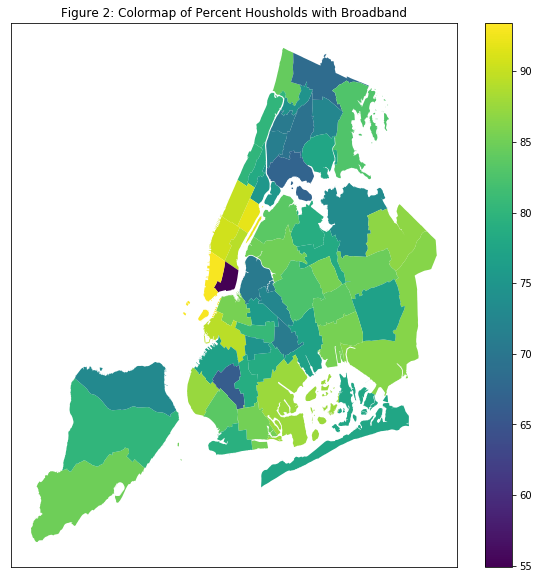

In [105]:
#Plot the dataframe, with the color map based on percent houses with broadband.
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
broadbandnyc.plot(column='pcBB',cmap='viridis',alpha=1,
                  linewidth=0.1,ax=ax, legend=True)
ax.set_title("Figure 2: Colormap of Percent Housholds with Broadband")

Figure 2 displays a colormap of the percentage of households with broadband, with yellow denoting high percentage and purple denoting low. One thing of interest is noting the the PUMA district containing the East village and the Lower East Side neighborhoods has the lowest value. Right next to it, however, the PUMA district right next to it, containing the neighborhoods of FiDi, TriBeCa, and West village, has the highest.

# Task 4

In [82]:
#Get the raw data for link NYC
!curl https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW7_fb55/linkNYClocations.csv?accessType=DOWNLOAD > linkNYClocations.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75571  100 75571    0     0   380k      0 --:--:-- --:--:-- --:--:--  382k


In [83]:
#Move data set into PUIDATA
!mv linkNYClocations.csv $PUIDATA

In [84]:
#Read in the data set as a dataframe
linkNYC = pd.read_csv(os.getenv("PUIDATA") + '/linkNYClocations.csv')
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [85]:
linkNYC.shape

(1414, 5)

In [86]:
#Merge longitude and latitude into one column
linkNYC['lonlat']=list(zip(linkNYC.longitude,linkNYC.latitude))
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)"
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)"
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)"
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)"
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)"


In [87]:
#Turn that data into point geometry
linkNYC['geometry']=linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat,geometry
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [88]:
#Convert to GeoDataFrame
linkNYC = GeoDataFrame(linkNYC)
linkNYC.crs = from_epsg(4326)
linkNYC.shape

(1414, 7)

Text(0.5,1,'Figure 3: Link Stations in NYC over Colormap of Percent Housholds with Broadband')

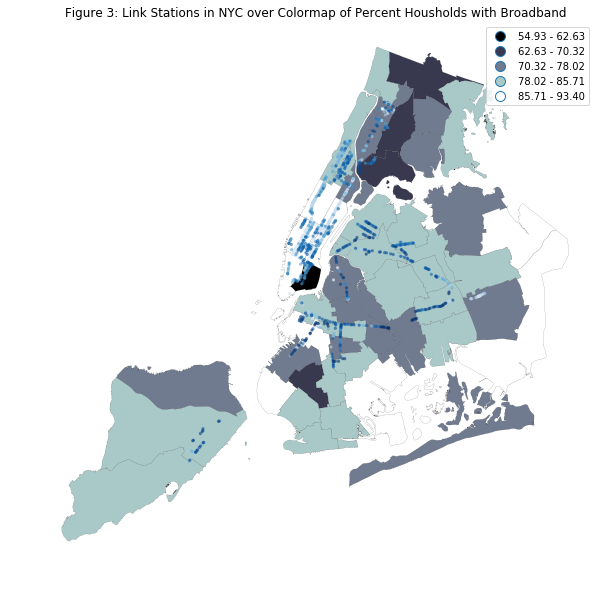

In [104]:
#Plot the dataset of linkNYC coordinates over the colormap of percent households with broadband
ig, ax = plt.subplots(1, figsize=(10,10))
base = broadbandnyc.plot(column='pcBB',cmap='bone', edgecolor = 'black',alpha=1,
                  linewidth=0.1,ax=ax, scheme="equal_interval", legend=True, k=5)
linkNYC.plot(ax=base, marker="o",c='date_link_', cmap ="Blues", markersize=5, alpha=0.5)
_ = ax.axis('off')
ax.set_title("Figure 3: Link Stations in NYC over Colormap of Percent Housholds with Broadband")

Figure 3 displays the same colormap of Figure 2, but with link NYC locations, displayed as blue dots, across the city. The color of the dots, depending on shade of blue, denotes when the station was built.

# Task 5

In [90]:
#Specify what info from the API you want
keyNpop = 'B00001_001E'
aff1y['variables'][keyNpop]

{'attributes': 'B00001_001EA',
 'concept': 'UNWEIGHTED SAMPLE COUNT OF THE POPULATION',
 'group': 'B00001',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [91]:
#Collect population data from the census api json file
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNpop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumapop = pd.read_csv(StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumapop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [92]:
#Convert 'puma' and 'public use microdata area' to integers and merge based on the values within these columns
nyc['puma'] = nyc['puma'].astype(int)
pumapop['public use microdata area'] = pumapop['public use microdata area'].astype(int)
nyc_pop = pd.merge(pumapop, nyc, left_on = 'public use microdata area', how = 'outer', right_on = 'puma')
nyc_pop.tail()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4,puma,shape_area,shape_leng,geometry
140,3259,"NYC-Queens Community District 5--Ridgewood, Gl...",36,4110,NaN,4110.0,2.050472e+08,71251.084890,POLYGON ((-73.89783236941891 40.73516035418231...
141,3124,NYC-Queens Community District 9--Richmond Hill...,36,4111,NaN,4111.0,1.326029e+08,56323.365530,POLYGON ((-73.82167849048575 40.71116601167973...
142,3940,"NYC-Queens Community District 12--Jamaica, Hol...",36,4112,NaN,4112.0,2.600517e+08,72781.304161,POLYGON ((-73.75725671377032 40.71813860165978...
143,2162,NYC-Queens Community District 10--Howard Beach...,36,4113,NaN,4113.0,1.714665e+08,110717.942782,(POLYGON ((-73.85722330984366 40.6502786705413...
144,1559,NYC-Queens Community District 14--Far Rockaway...,36,4114,NaN,4114.0,3.156828e+08,412606.741739,(POLYGON ((-73.83668274106707 40.5949466970158...


In [93]:
#Set to the reference frame 2263 so that they are flat coordinates
linkNYC.crs = from_epsg(2263)
nyc.crs = from_epsg(2263)

In [94]:
#Count the number of link sites per puma
linkpp = gpd.sjoin(linkNYC,nyc)[['puma', 'link_site']].groupby('puma', as_index = False).count()
linkpp.head()

,puma,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


In [95]:
#Convert to the a geodataframe and restore the previous reference system
linkpp = GeoDataFrame(linkpp)
linkpp.crs = from_epsg(4326)
linkpp.shape

(37, 2)

In [96]:
#Merge the two tables on the 'puma' columns
nycpop_df = pd.merge(linkpp, nyc_pop, left_on = 'puma', how = 'outer', right_on = 'puma')
nycpop_df.head()

,puma,link_site,B00001_001E,NAME,state,public use microdata area,Unnamed: 4,shape_area,shape_leng,geometry
0,3701.0,1.0,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3705.0,1.0,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,1.224951e+08,68657.316149,POLYGON ((-73.87359713633828 40.83979855593596...
2,3706.0,20.0,1274,"NYC-Bronx Community District 7--Bedford Park, ...",36,3706,NaN,4.388687e+07,51799.404183,"POLYGON ((-73.88785196328796 40.8721141761279,..."
3,3707.0,29.0,1548,NYC-Bronx Community District 5--Morris Heights...,36,3707,NaN,4.228113e+07,37347.925798,"POLYGON ((-73.89735765412577 40.8587627349268,..."
4,3708.0,19.0,1462,"NYC-Bronx Community District 4--Concourse, Hig...",36,3708,NaN,5.589695e+07,34852.437966,POLYGON ((-73.91046008330409 40.84279164297445...


In [97]:
#Calculate the ratio of link stations per 100 people
nycpop_df['linkNYCp100p'] = (nycpop_df['link_site']/nycpop_df['B00001_001E'])*100
nycpop_df.head()

,puma,link_site,B00001_001E,NAME,state,public use microdata area,Unnamed: 4,shape_area,shape_leng,geometry,linkNYCp100p
0,3701.0,1.0,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,0.065920
1,3705.0,1.0,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,1.224951e+08,68657.316149,POLYGON ((-73.87359713633828 40.83979855593596...,0.049727
2,3706.0,20.0,1274,"NYC-Bronx Community District 7--Bedford Park, ...",36,3706,NaN,4.388687e+07,51799.404183,"POLYGON ((-73.88785196328796 40.8721141761279,...",1.569859
3,3707.0,29.0,1548,NYC-Bronx Community District 5--Morris Heights...,36,3707,NaN,4.228113e+07,37347.925798,"POLYGON ((-73.89735765412577 40.8587627349268,...",1.873385
4,3708.0,19.0,1462,"NYC-Bronx Community District 4--Concourse, Hig...",36,3708,NaN,5.589695e+07,34852.437966,POLYGON ((-73.91046008330409 40.84279164297445...,1.299590


In [98]:
nycpop_df["linkNYCp100p"].describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: linkNYCp100p, dtype: float64

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


Text(0.5,1,'Figure 4: Link Stations in NYC over Colormap of Ratio of Citibike Locations per 100 People')

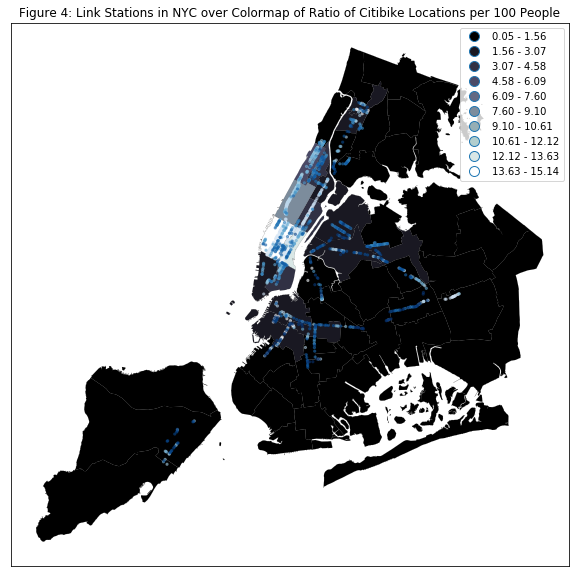

In [109]:
#Plot the dataset of linkNYC coordinates over the colormap of the ratio of linkNYC locations per 100 people
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
base = nycpop_df.plot(column='linkNYCp100p',cmap='bone', edgecolor='black', alpha=1,
                  linewidth=0.1,ax=ax, scheme="equal_interval", legend=True, k=10)
linkNYC.plot(ax=base, marker="o",c='date_link_', cmap ="Blues", markersize=5, alpha=0.5)
ax.set_title("Figure 4: Link Stations in NYC over Colormap of Ratio of Citibike Locations per 100 People")

Figure 4 displays a color map of the ratio of link locations per 100 people. Overlayed ontop is the same linkNYC locations shown in figure 3. 